# Explore candidates matched to stars

Thoughts of things we could do with stars for a section of the paper.

 * Plot a histogram of the light curve time span for candidates matched to stars. Is it bimodal? I.e., flares and variables?

 * How many potential stars have light curves that can be fit with a periodigram?

 * Explore the distributions of derived periods. What are most of these potential stars?

## Set up

Import packages and define plotting parameters.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import astropy.units as u
from astropy.table import unique
from astropy.timeseries import LombScargle

In [2]:
all_filters = np.asarray(['g','r','i'], dtype='str')
all_fcolors = np.asarray(['green','red','blue'], dtype='str')
all_fshapes = np.asarray(['o','s','^'], dtype='str')
all_fsizes  = np.asarray([5, 5, 7], dtype='int')

Read in the nightly-epoch light curves and their measured parameters.

In [3]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

In [4]:
fnm = '../all_nightly_epochs_files/candidate_lightcurve_parameters.dat'
paramLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
paramLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
paramLC_tspan = np.loadtxt(fnm, dtype='float', usecols=(2))
paramLC_tspan_g = np.loadtxt(fnm, dtype='float', usecols=(3))
paramLC_tspan_r = np.loadtxt(fnm, dtype='float', usecols=(4))
paramLC_tspan_i = np.loadtxt(fnm, dtype='float', usecols=(5))
paramLC_minmag = np.loadtxt(fnm, dtype='float', usecols=(6))
paramLC_minmag_g = np.loadtxt(fnm, dtype='float', usecols=(7))
paramLC_minmag_r = np.loadtxt(fnm, dtype='float', usecols=(8))
paramLC_minmag_i = np.loadtxt(fnm, dtype='float', usecols=(9))
paramLC_amp = np.loadtxt(fnm, dtype='float', usecols=(10))
paramLC_amp_g = np.loadtxt(fnm, dtype='float', usecols=(11))
paramLC_amp_r = np.loadtxt(fnm, dtype='float', usecols=(12))
paramLC_amp_i = np.loadtxt(fnm, dtype='float', usecols=(13))
paramLC_neps = np.loadtxt(fnm, dtype='int', usecols=(14))
paramLC_neps_g = np.loadtxt(fnm, dtype='int', usecols=(15))
paramLC_neps_r = np.loadtxt(fnm, dtype='int', usecols=(16))
paramLC_neps_i = np.loadtxt(fnm, dtype='int', usecols=(17))
del fnm

Read in all rows of the cross-matched file.

`flagstar` : 1 if matched to a star; 0 if matched to a galaxy; -1 if unmatched (int) 

`flagcore` : 1 if matched to the core of the galaxy; 0 otherwise (int) 

`flagmatch` : 1 if a star AND galaxy met constraints; 0 if one or the other; -1 if unmatched (int) 

In [5]:
fnm = '../cross_matched_LSDR10/candidate_xmatch_LSdr10.dat'
lsdr10xm_candid   = np.loadtxt(fnm, dtype='str', usecols=(0))
lsdr10xm_candra   = np.loadtxt(fnm, dtype='float', usecols=(1))
lsdr10xm_canddec  = np.loadtxt(fnm, dtype='float', usecols=(2))
lsdr10xm_flagstar = np.loadtxt(fnm, dtype='int', usecols=(4))
lsdr10xm_flagcore = np.loadtxt(fnm, dtype='int', usecols=(5))
lsdr10xm_flagmatch= np.loadtxt(fnm, dtype='int', usecols=(6))
lsdr10xm_sep      = np.loadtxt(fnm, dtype='float', usecols=(7))
lsdr10xm_ra       = np.loadtxt(fnm, dtype='float', usecols=(8))
lsdr10xm_dec      = np.loadtxt(fnm, dtype='float', usecols=(9))
lsdr10xm_rmag     = np.loadtxt(fnm, dtype='float', usecols=(13))
lsdr10xm_type     = np.loadtxt(fnm, dtype='str', usecols=(15))
lsdr10xm_shaper   = np.loadtxt(fnm, dtype='float', usecols=(19))
lsdr10xm_rpsfsize = np.loadtxt(fnm, dtype='float', usecols=(21))  
lsdr10xm_meanpz   = np.loadtxt(fnm, dtype='float', usecols=(23))
lsdr10xm_stdpz    = np.loadtxt(fnm, dtype='float', usecols=(24))
lsdr10xm_specz    = np.loadtxt(fnm, dtype='float', usecols=(25))
del fnm

Cross-match between the `lsdr10xm_` arrays and `paramLC_` arrays.

In [6]:
paramLC_xindex = np.zeros(len(paramLC_candid), dtype='int') - 1
lsdr10xm_pindex = np.zeros(len(lsdr10xm_candid), dtype='int') -1

for px in range(len(paramLC_candid)):
    tx = np.where(paramLC_candid[px] == lsdr10xm_candid)[0]
    if len(tx) == 1:
        paramLC_xindex[px] = tx[0]
        lsdr10xm_pindex[tx[0]] = px
    else:
        print(paramLC_candid[px], len(tx))
    del tx
del px

Reminder of how many candidates are matched to stars vs. galaxies.

In [7]:
sx = np.where(lsdr10xm_flagstar == 1)[0]
gx = np.where(lsdr10xm_flagstar == 0)[0]
print('Number of candidates matched to:')
print('stars: ', len(sx))
print('galaxies: ', len(gx))
del sx, gx

Number of candidates matched to:
stars:  6290
galaxies:  2587


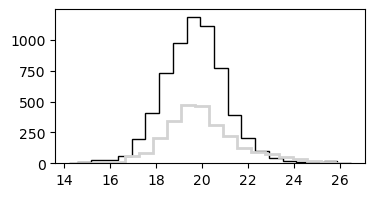

In [8]:
plt.figure(figsize=(4, 2))
sx = np.where(lsdr10xm_flagstar == 1)[0]
gx = np.where(lsdr10xm_flagstar == 0)[0]
plt.hist(lsdr10xm_rmag[sx], bins=20, lw=1, histtype='step', color='black', label='stars')
plt.hist(lsdr10xm_rmag[gx], bins=20, lw=2, histtype='step', color='lightgrey', label='galaxies')
plt.show()

## Illustrate the light curve parameters for candidates matched to stars

Histograms of the light curve parameters for candidates matched to stars and galaxies.

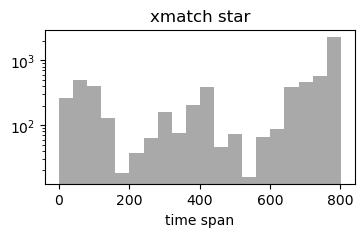

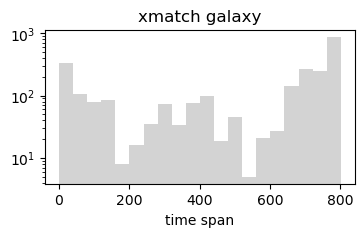

In [9]:
# plt.figure(figsize=(4, 2))
# plt.hist(paramLC_tspan, bins=20, log=True, color='grey')
# plt.xlabel('time span')
# plt.title('all')
# plt.show

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist(paramLC_tspan[px], bins=20, log=True, color='darkgrey')
plt.xlabel('time span')
plt.title('xmatch star')
plt.show()
del tx, px

tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist(paramLC_tspan[px], bins=20, log=True, color='lightgrey')
plt.xlabel('time span')
plt.title('xmatch galaxy')
plt.show()
del tx, px

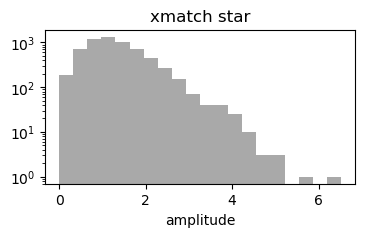

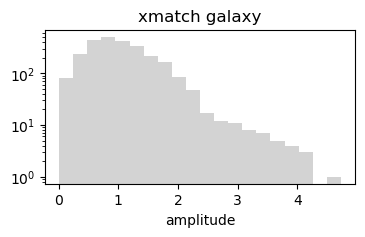

In [10]:
# plt.figure(figsize=(4, 2))
# plt.hist(paramLC_amp, bins=20, log=True, color='grey')
# plt.xlabel('amplitude')
# plt.title('all')
# plt.show

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist(paramLC_amp[px], bins=20, log=True, color='darkgrey')
plt.xlabel('amplitude')
plt.title('xmatch star')
plt.show()
del tx, px

tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist(paramLC_amp[px], bins=20, log=True, color='lightgrey')
plt.xlabel('amplitude')
plt.title('xmatch galaxy')
plt.show()
del tx, px

Scatter plots like in the paper, but just for candidates matched to stars or galaxies.

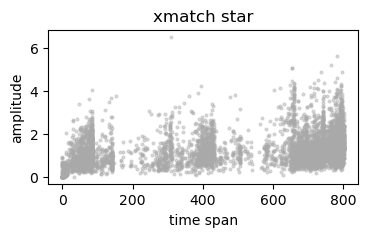

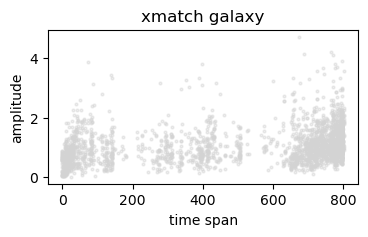

In [11]:
# plt.figure(figsize=(4, 2))
# plt.plot(paramLC_tspan, paramLC_amp, 'o', ms=2, alpha=0.4, color='grey')
# plt.xlabel('time span')
# plt.ylabel('amplitude')
# plt.title('all')
# plt.show

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.plot(paramLC_tspan[px], paramLC_amp[px], 'o', ms=2, alpha=0.4, color='darkgrey')
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('xmatch star')
plt.show()
del tx, px

tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.plot(paramLC_tspan[px], paramLC_amp[px], 'o', ms=2, alpha=0.4, color='lightgrey')
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('xmatch galaxy')
plt.show()
del tx, px

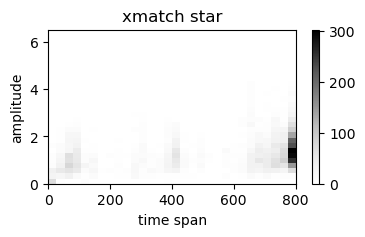

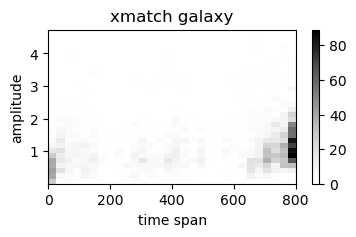

In [12]:
# plt.figure(figsize=(4, 2))
# plt.hist2d(paramLC_tspan, paramLC_amp, bins=30, cmap='Greys')
# plt.colorbar()
# plt.xlabel('time span')
# plt.ylabel('amplitude')
# plt.title('all')
# plt.show

tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist2d(paramLC_tspan[px], paramLC_amp[px], bins=30, cmap='Greys')
plt.colorbar()
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('xmatch star')
plt.show()
del tx, px

tx = np.where(lsdr10xm_flagstar == 0)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.hist2d(paramLC_tspan[px], paramLC_amp[px], bins=30, cmap='Greys')
plt.colorbar()
plt.xlabel('time span')
plt.ylabel('amplitude')
plt.title('xmatch galaxy')
plt.show()
del tx, px

We have difference image photometry, but the matched objects have direct image photometry.

Check the correlations -- brighter stars should have larger variability amplitude.

And should be able to see saturated stars as well?

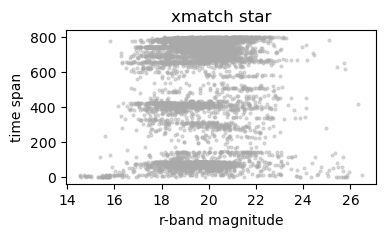

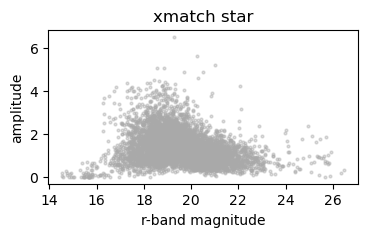

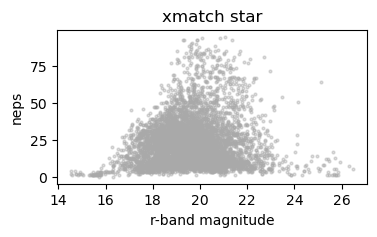

In [13]:
tx = np.where(lsdr10xm_flagstar == 1)[0]
px = lsdr10xm_pindex[tx]
plt.figure(figsize=(4, 2))
plt.plot(lsdr10xm_rmag[tx], paramLC_tspan[px], 'o', ms=2, alpha=0.4, color='darkgrey')
plt.xlabel('r-band magnitude')
plt.ylabel('time span')
plt.title('xmatch star')
plt.show()

plt.figure(figsize=(4, 2))
plt.plot(lsdr10xm_rmag[tx], paramLC_amp[px], 'o', ms=2, alpha=0.4, color='darkgrey')
plt.xlabel('r-band magnitude')
plt.ylabel('amplitude')
plt.title('xmatch star')
plt.show()

plt.figure(figsize=(4, 2))
plt.plot(lsdr10xm_rmag[tx], paramLC_neps[px], 'o', ms=2, alpha=0.4, color='darkgrey')
plt.xlabel('r-band magnitude')
plt.ylabel('neps')
plt.title('xmatch star')
plt.show()

del tx, px

Looks like bright stars are mag < 17, can see them as a separate group, probably saturated.

## Try a periodogram for a random candidate

Aim to pick out an RRLyrae or Cepheid.

So the amplitude should be 0.5 to 1.5 mag, and let's say the brightness of 18 to 20 mag.

Attempt a periodogram with it.

In [14]:
tx = np.where((lsdr10xm_flagstar == 1) & (lsdr10xm_rmag > 18) & (lsdr10xm_rmag < 20))[0]
px = lsdr10xm_pindex[tx]

ix = np.where((paramLC_amp[px] > 0.5) & (paramLC_amp[px] < 1.5) & 
              (paramLC_tspan[px] > 40) &  (paramLC_neps[px] > 30))[0]
print(len(ix), ' out of ', len(px), ' candidates meet the conditions.')

rx = np.random.choice(len(ix), 1)
x = px[ix[rx]]
print('randomly selected candidate: ', paramLC_candid[x], ' rmag=', lsdr10xm_rmag[x])
cand = paramLC_candid[x]
del tx, px, ix, rx, x

303  out of  3165  candidates meet the conditions.
randomly selected candidate:  ['DC21flgn']  rmag= [19.092]


Index the parameters and light curve points that belong to this candidate.

In [15]:
px = np.where(paramLC_candid == cand)[0]
cx = np.where(candLC_candid == cand)[0]

Print some parameters for this candidate.

In [16]:
print(paramLC_field[px[0]], paramLC_candid[px[0]])
print(' ')
print('       %6s %6s %6s %6s ' % ('all', 'g', 'r', 'i'))
print('tspan  %6.1f %6.1f %6.1f %6.1f' % (paramLC_tspan[px[0]], paramLC_tspan_g[px[0]], paramLC_tspan_r[px[0]], paramLC_tspan_i[px[0]]))
print('minmag %6.1f %6.1f %6.1f %6.1f' % (paramLC_minmag[px[0]], paramLC_minmag_g[px[0]], paramLC_minmag_r[px[0]], paramLC_minmag_i[px[0]]))
print('amp    %6.1f %6.1f %6.1f %6.1f' % (paramLC_amp[px[0]], paramLC_amp_g[px[0]], paramLC_amp_r[px[0]], paramLC_amp_i[px[0]]))
print('neps   %6i %6i %6i %6i' % (paramLC_neps[px[0]], paramLC_neps_g[px[0]], paramLC_neps_r[px[0]], paramLC_neps_i[px[0]]))

COSMOS DC21flgn
 
          all      g      r      i 
tspan   787.9   38.9  787.9    0.0
minmag   20.5   20.7   20.5    0.0
amp       1.4    0.5    1.4    0.0
neps       45      8     43      0


Choose the filter based on the above.

In [17]:
usefilt = 'r'

Show the light curve.

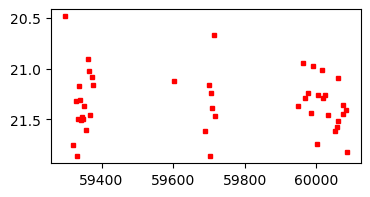

In [18]:
fx = np.where(candLC_filter[cx] == usefilt)[0]
days = candLC_mjd[cx[fx]]
mags = candLC_mag[cx[fx]]

x = np.where(all_filters == usefilt)[0]
sym = all_fshapes[x[0]]
clr = all_fcolors[x[0]]

plt.figure(figsize=(4, 2))
plt.plot(days, mags, sym, ms=3, color=clr)
plt.gca().invert_yaxis()
plt.show()

del x, sym, clr

For RR Lyrae the periods are ~half a day, but Cepheids can be longer, ~10 days. So try that range.

In [19]:
min_p = 0.1 * u.day
max_p = 20.1 * u.day
min_f = 1.0 / max_p
max_f = 1.0 / min_p

Do the Lomb Scargle periodogram fit.

In [20]:
frequency, power = LombScargle(days * u.day, mags).autopower(minimum_frequency=min_f, maximum_frequency=max_f)

In [21]:
print(np.min(power), np.max(power))
print(np.mean(power), np.std(power))
print((np.max(power)-np.mean(power))/np.std(power))

2.384612187464181e-07 0.3955879095483205
0.04562144968540825 0.043577259399190146
8.03094239261444


Show the results.

Take as the best period the highest power peak.

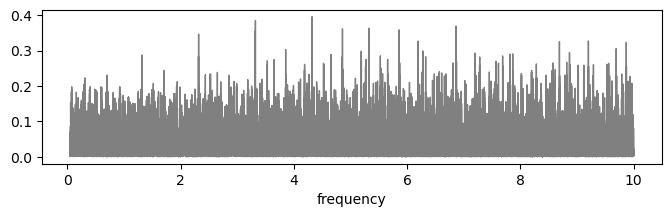

best period:  0.23135669123890643  in days


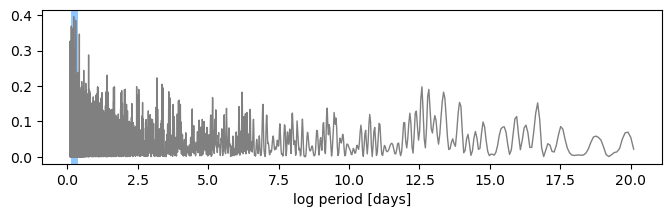

In [22]:
plt.figure(figsize=(8, 2))
plt.plot(frequency, power, color='grey', lw=1)
plt.xlabel('frequency')
plt.show()

tmp = np.argsort(power)
sx = tmp[::-1]
best_period = 1 / frequency[sx[0]].value
print('best period: ', best_period, ' in days')
del tmp, sx

plt.figure(figsize=(8, 2))
# plt.axvline(np.log10(best_period), color='dodgerblue', lw=5, alpha=0.5)
# plt.plot(np.log10(1 / frequency.value), power, color='grey', lw=1)
plt.axvline(best_period, color='dodgerblue', lw=5, alpha=0.5)
plt.plot(1 / frequency.value, power, color='grey', lw=1)
plt.xlabel('log period [days]')
plt.show()

Phase-fold the light curve and plot it.

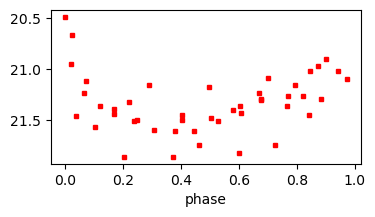

In [23]:
t0 = np.min(days)
days_norm = (days - t0) / best_period
phase = np.mod(days_norm, 1.0)
del t0

x = np.where(all_filters == usefilt)[0]
sym = all_fshapes[x[0]]
clr = all_fcolors[x[0]]

plt.figure(figsize=(4, 2))
plt.plot(phase, mags, sym, ms=3, color=clr)
plt.xlabel('phase')
plt.gca().invert_yaxis()
plt.show()

Alright that random one didn't really work.

When the best period is one day, it's probably aliasing.... out but let's try for more.

## Try periodograms to identify longer duration variable stars

`Pbest` will be the best period.

`Ppwr` will be the power in that period.

`Psnr` with be the 'signal-to-noise ratio' for the best period: (max(power)-mean(power)) / std(power)

In [24]:
paramLC_Pbest_g = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Pbest_r = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Pbest_i = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Psnr_g = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Psnr_r = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Psnr_i = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Ppwr_g = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Ppwr_r = np.zeros(len(paramLC_candid), dtype='float') - 1.0
paramLC_Ppwr_i = np.zeros(len(paramLC_candid), dtype='float') - 1.0

Go after longer duration variables.

https://www.aanda.org/articles/aa/full_html/2014/06/aa23252-13/F14.html

In [25]:
min_p = 5.1 * u.day
max_p = 40.1 * u.day
min_f = 1.0 / max_p
max_f = 1.0 / min_p

Make the periodograms for all candidates matched to stars that have sufficient time span, amplitude, and number of epochs.

In [26]:
min_tspan = 100
min_amp = 0.5
min_neps = 40

In [27]:
t1 = time.time()

for p in range(len(paramLC_candid)):

    if (p == 10) | (p == 100) | (p == 1000):
        t2 = time.time()
        print('p=%6i, %5.1f seconds remain' % (p, ((t2-t1)/float(p))*(float(len(paramLC_candid)-p))))
    
    if (lsdr10xm_flagstar[paramLC_xindex[p]] == 1) & \
    (paramLC_tspan[p] > min_tspan) & (paramLC_amp[p] > min_amp) & \
    (paramLC_neps[p] > min_neps):
        tmp1 = np.zeros(3, dtype='float')
        tmp2 = np.zeros(3, dtype='float')
        tmp3 = np.zeros(3, dtype='float')

        for f, filt in enumerate(all_filters):
            x = np.where((candLC_candid == paramLC_candid[p]) & 
                         (candLC_filter == filt))[0]

            if len(x) > 30:
                days = candLC_mjd[x]
                mags = candLC_mag[x]
                frequency, power = LombScargle(days * u.day, mags).autopower(minimum_frequency=min_f, 
                                                                             maximum_frequency=max_f)
                mx = np.argmax(power)
                tmp1[f] = 1 / frequency[mx].value
                tmp2[f] = (np.max(power)-np.mean(power))/np.std(power)
                tmp3[f] = np.max(power)
                del days, mags, frequency, power, mx
            del x

        paramLC_Pbest_g[p] = tmp1[0]
        paramLC_Pbest_r[p] = tmp1[1]
        paramLC_Pbest_i[p] = tmp1[2]
        paramLC_Psnr_g[p] = tmp2[0]
        paramLC_Psnr_r[p] = tmp2[1]
        paramLC_Psnr_i[p] = tmp2[2]
        paramLC_Ppwr_g[p] = tmp3[0]
        paramLC_Ppwr_r[p] = tmp3[1]
        paramLC_Ppwr_i[p] = tmp3[2]
        del tmp1, tmp2
        
t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))
del t1, t2

p=    10,   7.0 seconds remain
p=   100,   1.2 seconds remain
p=  1000,   1.3 seconds remain
elapsed:   4.3


Explore the periodogram results by plotting them.

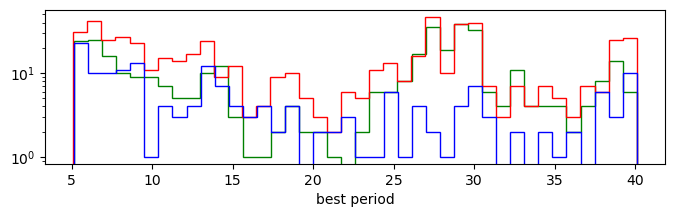

In [28]:
plt.figure(figsize=(8, 2))
gx = np.where(paramLC_Pbest_g > 0.0)[0]
rx = np.where(paramLC_Pbest_r > 0.0)[0]
ix = np.where(paramLC_Pbest_i > 0.0)[0]
plt.hist(paramLC_Pbest_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
plt.hist(paramLC_Pbest_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
plt.hist(paramLC_Pbest_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
del gx, rx, ix
plt.xlabel('best period')
plt.show()

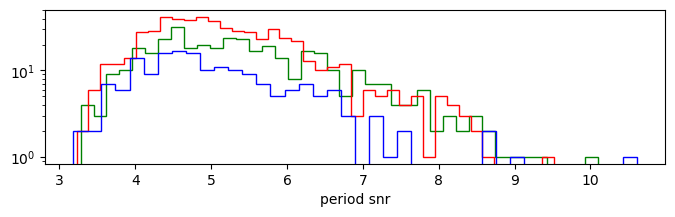

In [29]:
plt.figure(figsize=(8, 2))
gx = np.where(paramLC_Psnr_g > 0.0)[0]
rx = np.where(paramLC_Psnr_r > 0.0)[0]
ix = np.where(paramLC_Psnr_i > 0.0)[0]
plt.hist(paramLC_Psnr_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
plt.hist(paramLC_Psnr_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
plt.hist(paramLC_Psnr_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
del gx, rx, ix
plt.xlabel('period snr')
plt.show()

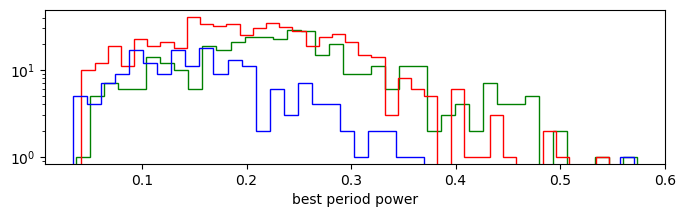

In [30]:
plt.figure(figsize=(8, 2))
gx = np.where(paramLC_Ppwr_g > 0.0)[0]
rx = np.where(paramLC_Ppwr_r > 0.0)[0]
ix = np.where(paramLC_Ppwr_i > 0.0)[0]
plt.hist(paramLC_Ppwr_g[gx], bins=40, histtype='step', log=True, color=all_fcolors[0])
plt.hist(paramLC_Ppwr_r[rx], bins=40, histtype='step', log=True, color=all_fcolors[1])
plt.hist(paramLC_Ppwr_i[ix], bins=40, histtype='step', log=True, color=all_fcolors[2])
del gx, rx, ix
plt.xlabel('best period power')
plt.show()

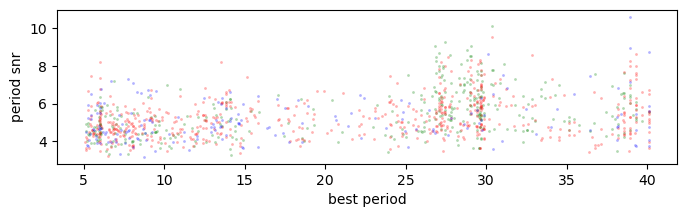

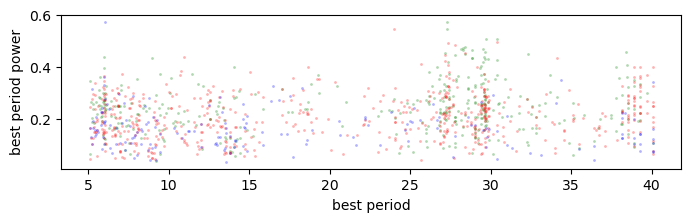

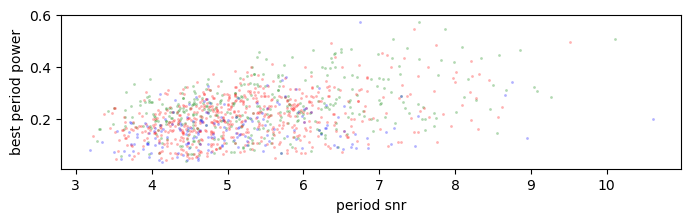

In [31]:
gx = np.where(paramLC_Pbest_g > 0.0)[0]
rx = np.where(paramLC_Pbest_r > 0.0)[0]
ix = np.where(paramLC_Pbest_i > 0.0)[0]

plt.figure(figsize=(8, 2))
plt.plot(paramLC_Pbest_g[gx], paramLC_Psnr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
plt.plot(paramLC_Pbest_r[rx], paramLC_Psnr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
plt.plot(paramLC_Pbest_i[ix], paramLC_Psnr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
plt.xlabel('best period')
plt.ylabel('period snr')
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(paramLC_Pbest_g[gx], paramLC_Ppwr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
plt.plot(paramLC_Pbest_r[rx], paramLC_Ppwr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
plt.plot(paramLC_Pbest_i[ix], paramLC_Ppwr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
plt.xlabel('best period')
plt.ylabel('best period power')
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(paramLC_Psnr_g[gx], paramLC_Ppwr_g[gx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[0])
plt.plot(paramLC_Psnr_r[rx], paramLC_Ppwr_r[rx], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[1])
plt.plot(paramLC_Psnr_i[ix], paramLC_Ppwr_i[ix], 'o', ms=2, alpha=0.3, mew=0, color=all_fcolors[2])
plt.xlabel('period snr')
plt.ylabel('best period power')
plt.show()

del gx, rx, ix

In [32]:
# x1 = np.where((paramLC_Pbest_r > 0.0) & (paramLC_Pbest_g > 0.0) & (paramLC_Psnr_r > 10.0) & (paramLC_Psnr_g > 10.0))[0]
# x2 = np.where((paramLC_Pbest_r > 0.0) & (paramLC_Pbest_i > 0.0) & (paramLC_Psnr_r > 10.0) & (paramLC_Psnr_i > 10.0))[0]

# plt.figure(figsize=(3, 3))
# # plt.plot([0, 3], [0, 3])
# # plt.plot(paramLC_Pbest_r[x1], paramLC_Pbest_g[x1], 'o', ms=4, alpha=0.3, mew=0, color='grey')
# plt.hist2d(paramLC_Pbest_r[x1], paramLC_Pbest_g[x1], bins=20, cmap='Greys')
# plt.xlabel('best period r')
# plt.ylabel('best period g')
# plt.xlim([-0.2, 3.2])
# plt.ylim([-0.2, 3.2])
# plt.show()

# plt.figure(figsize=(3, 3))
# # plt.plot([0, 3], [0, 3])
# # plt.plot(paramLC_Pbest_r[x2], paramLC_Pbest_i[x2], 'o', ms=4, alpha=0.3, mew=0, color='grey')
# plt.hist2d(paramLC_Pbest_r[x2], paramLC_Pbest_g[x2], bins=20, cmap='Greys')
# plt.xlabel('best period r')
# plt.ylabel('best period i')
# plt.xlim([-0.2, 3.2])
# plt.ylim([-0.2, 3.2])
# plt.show()

# del x1, x2

## Next steps

Check out a few of the best, with the highest snr and powers.

Can downselect by looking for candidates that had similar periods in more than one band.